In [ ]:
#@title Imports

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms
from tqdm import tqdm

In [ ]:
BATCH_SIZE = 128
NUM_EPOCHS = 5
T = 1000 # Timesteps
IMG_SIZE = 32
UNET_EXP = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


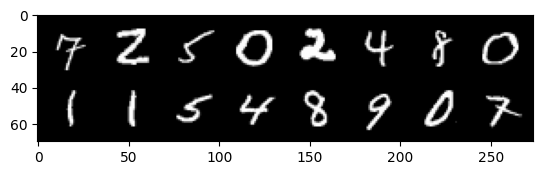

In [ ]:
#@title MNIST Dataset

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((2, 2, 2, 2)),
])
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=data_transform)
val_dataset = torchvision.datasets.MNIST(root="mnist/", train=False, download=True, transform=data_transform
                                         )
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

x, y = next(iter(train_dataloader))
x = x[:16]
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="gray")

In [83]:
#@title Linear, cosine noise scheduler

class LinearNoiseScheduler(nn.Module):
    def __init__(self, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__()
        self.timesteps = timesteps

        # Linearly spaced betas
        betas = torch.linspace(beta_start, beta_end, timesteps)

        # Precompute alphas and their cumulative products
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        # Register buffers (they move with the model to device, are saved with state_dict)
        self.register_buffer("betas", betas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor, t: torch.Tensor):
        """
        Add noise to input `x` at timestep `t`.

        Args:
            x: Tensor of shape (B, C, H, W)
            t: Tensor of shape (B,) with integer timesteps (0 <= t < T)

        Returns:
            noisy_x: noised version of `x`
            noise: the noise added
        """
        B, C, H, W = x.shape

        # Get alpha_cumprod_t for each sample in the batch
        alpha_cumprod_t = self.alphas_cumprod[t].view(B, 1, 1, 1)  # Shape (B, 1, 1, 1)

        # Apply noise: x_t = sqrt(a_t) * x + sqrt(1 - a_t) * noise
        noisy_x = torch.sqrt(alpha_cumprod_t) * x + torch.sqrt(1 - alpha_cumprod_t) * noise

        return noisy_x

class CosineNoiseScheduler(nn.Module):
    """
    s = 0.008 is set by the authors of the paper (section 3.2)
    """
    def __init__(self, timesteps = 1000, s=0.008):
        self.timesteps = timesteps
        self.s = s
        self.betas = self._cosine_beta_schedule()
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def to(self, device):
        self.device = device

        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alpha_cumprod = self.alpha_cumprod.to(device)


    def _cosine_beta_schedule(self):
        steps = self.timesteps + 1
        t = torch.linspace(0, self.timesteps, steps) / self.timesteps
        alphas_bar = torch.cos(((t + self.s) / (1 + self.s)) * math.pi * 0.5) ** 2 # Formula 2
        alphas_bar = alphas_bar / alphas_bar[0] # formula 1
        betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
        return torch.clamp(betas, max=0.999)

    def add_noise(self, x: torch.Tensor, noise: torch.Tensor ,t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Adds "t" noise to "x0"

        x:      [B, C, H, W]
        noise:  [B, C, H, W]
        t:      [B, ]

        Returns:
            x_t: the noisy image at timestep t
            noise: the noise that was added
        """
        alpha_bar = self.alpha_cumprod[t.long()].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise

# Model

In [84]:
#@title Sinusodial embeddings

class SinusoidalEmbedding(torch.nn.Module):
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim
        assert self.embedding_dim % 2 == 0, "embedding_dim must be even"

    def to(self, device):
        super().to(device)
        self.device = device
        return self

    def forward(self, timesteps: Tensor) -> Tensor:
        # Create the frequency spectrum
        half_dim = self.embedding_dim // 2
        exponent = -math.log(10000.0) / (half_dim - 1)
        freq = torch.exp(torch.arange(half_dim, dtype=torch.float32) * exponent).to(self.device)
        # freq = freq.to(self.device)

        # Expand timesteps for broadcasting
        timesteps = timesteps.float().unsqueeze(1)  # (N, 1)
        args = timesteps * freq.unsqueeze(0)        # (N, half_dim)

        # Concatenate sin and cos
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # (N, embedding_dim)

        return embedding

In [85]:
#@title Downsampling + DoubleConv

"""
From the paper:
"It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) [i.e. DoubleConvolution module] and a 2x2 max pooling operation with stride 2 for downsampling [i.e. DownSampling module]."
"""
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)

class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvolution(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        pool = self.pool(down)

        return down, pool

"""
From the paper:
"Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU"
"""
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConvolution(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat((x1, x2), dim=1)
        return self.conv(x)


Self-attention can be described like a Google query:

Query: what we are looking for (like Google search query)
Key: tag or identity or keywords of websites that Google indexs
Value: the full webpage of the website that Google indexed

Basically we type query, Google computes how similar the query is to each key (via dot product), Google uses similarity scores to weight the values (the actual content of each document), and the result is a mixture of different websites (weighted values), not just a single website.

**Pixel attention**: attention allows every pixel to attend to every other pixel, resulting in features



In [86]:
#@title SelfAttention2d + AttnDownSampling

class SelfAttention2d(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key   = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv1d(in_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))  # Learnable scaling factor

    def forward(self, x: torch.Tensor):
        """
        Input: [B, C, H, W]
        Output: [B, C, H, W]
        """
        B, C, H, W = x.shape
        x_flat = rearrange(x, "b c h w -> b c (h w)") # [B, C, H*W]

        Q = self.query(x_flat)    # [B, C//8, H*W]
        K = self.key(x_flat)      # [B, C//8, H*W]
        V = self.value(x_flat)    # [B, C, H*W]

        attention = torch.bmm(Q.permute(0, 2, 1), K)  # [B, H*W, H*W]
        attention = F.softmax(attention / (C ** 0.5), dim=-1)

        out = torch.bmm(V, attention)  # [B, C, H*W]
        out = out.view(B, C, H, W)

        return self.gamma * out + x  # Residual connection

class AttnDownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvolution(in_channels, out_channels)
        self.attn = SelfAttention2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        attn_out = self.attn(down)
        pool = self.pool(attn_out)
        return attn_out, pool


In [87]:
#@title The U-Net

class UNet(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int):
        super().__init__()

        exp = UNET_EXP

        self.time_embedding = SinusoidalEmbedding(time_emb_dim)

        # Project time embeddings to match each block's input channels
        self.time_proj1 = nn.Linear(time_emb_dim, 2 ** (exp + 0))
        self.time_proj2 = nn.Linear(time_emb_dim, 2 ** (exp + 1))
        self.time_proj3 = nn.Linear(time_emb_dim, 2 ** (exp + 2))
        self.time_proj4 = nn.Linear(time_emb_dim, 2 ** (exp + 3))
        self.time_proj_bottleneck = nn.Linear(time_emb_dim, 2 ** (exp + 4))

        self.dconv1 = DownSampling(in_channels, 2 ** (exp+0))
        self.dconv2 = AttnDownSampling(2 ** (exp+0), 2 ** (exp+1))
        self.dconv3 = AttnDownSampling(2 ** (exp+1), 2 ** (exp+2))
        self.dconv4 = DownSampling(2 ** (exp+2), 2 ** (exp+3))

        self.bottle_neck = DoubleConvolution(2 ** (exp+3), 2 ** (exp+4))

        self.uconv1 = UpSampling(2 ** (exp+4), 2 ** (exp+3))
        self.uconv2 = UpSampling(2 ** (exp+3), 2 ** (exp+2))
        self.uconv3 = UpSampling(2 ** (exp+2), 2 ** (exp+1))
        self.uconv4 = UpSampling(2 ** (exp+1), 2 ** (exp+0))

        self.out = nn.Conv2d(2 ** (exp+0), out_channels, kernel_size=1)

    def to(self, device):
        super().to(device)
        self.device = device
        self.time_embedding.to(device)

        return self

    def forward(self, x: Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
            x: [B, C, H, W]: Must be divisible by 2^4 (number of downsampling/upsampling blocks)
        """
        assert x.ndim == 4
        assert x.shape[2] % (2 ** 4) == 0, "x must be divisible by 2^4"
        assert x.shape[3] % (2 ** 4) == 0, "x must be divisible by 2^4"

        # Generate time embeddings
        t_emb = self.time_embedding(t)  # (B, time_emb_dim)

        # Project to feature dims
        t1 = self.time_proj1(t_emb).unsqueeze(-1).unsqueeze(-1)  # (B, C, 1, 1)
        t2 = self.time_proj2(t_emb).unsqueeze(-1).unsqueeze(-1)
        t3 = self.time_proj3(t_emb).unsqueeze(-1).unsqueeze(-1)
        t4 = self.time_proj4(t_emb).unsqueeze(-1).unsqueeze(-1)
        t_b = self.time_proj_bottleneck(t_emb).unsqueeze(-1).unsqueeze(-1)

        # Down path with time embeddings
        d1,p1 = self.dconv1(x)
        d1 = d1 + t1

        d2,p2 = self.dconv2(p1)
        d2 = d2 + t2

        d3,p3 = self.dconv3(p2)
        d3 = d3 + t3

        d4,p4 = self.dconv4(p3)
        d4 = d4 + t4

        b = self.bottle_neck(p4)
        b = b + t_b

        # Up path
        u1 = self.uconv1(b, d4)
        u2 = self.uconv2(u1, d3)
        u3 = self.uconv3(u2, d2)
        u4 = self.uconv4(u3, d1)

        out = self.out(u4)
        return out

In [ ]:
#@title Final model class

class Model(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, time_emb_dim: int):
        super().__init__()

        self.input_channels = in_channels
        self.criterion = nn.MSELoss()

        beta_schedule = torch.linspace(1e-4, 0.02, T + 1, device=device)
        alpha_t_schedule = 1 - beta_schedule
        bar_alpha_t_schedule = torch.cumprod(alpha_t_schedule.detach().cpu(), 0).to(device)
        self.sqrt_bar_alpha_t_schedule = torch.sqrt(bar_alpha_t_schedule)
        self.sqrt_minus_bar_alpha_t_schedule = torch.sqrt(1 - bar_alpha_t_schedule)

        # U-Net selection
        self.unet = UNet(in_channels=in_channels, out_channels=out_channels, time_emb_dim=time_emb_dim)

    def to(self, device):
        super().to(device)
        self.unet.to(device)
        return self
    
    def calculate_loss(self, imgs: torch.Tensor):
        t = torch.randint(low=1, high=T+1, size=(imgs.shape[0],), device=device)
        noise = torch.randn_like(imgs, device=device)

        # get noise image as: sqrt(alpha_t_bar) * x0 + noise * sqrt(1 - alpha_t_bar)
        b, c, h, w = imgs.shape
        noise_imgs = self.sqrt_bar_alpha_t_schedule[t].view((b, 1, 1 ,1)) * imgs \
            + self.sqrt_minus_bar_alpha_t_schedule[t].view((b, 1, 1, 1)) * noise
        
        # get predicted noise from our model
        pred_noise = self.unet(noise_imgs, t.unsqueeze(1))

        # calculate of Loss simple ||noise - pred_noise||^2, which is MSELoss
        return self.criterion(pred_noise, noise)

    @torch.no_grad()
    def sample(self, n_steps: int = 40, batch: int = 64) -> torch.Tensor:
      """
      Generate batch of samples by running reverse diffusion.
      """
      self.eval()
      x = torch.randn(batch, 1, IMG_SIZE, IMG_SIZE).to(device)

      for i in reversed(range(n_steps)):
          t = torch.full((batch,), i, dtype=torch.long)
          t = t.to(device)

          pred = self.unet(x, t)

          # Assume pred is x_0 (clean image), and you have a scheduler that tells how to denoise
          # For now, a simple interpolation toward pred
          x = pred  # Or: x = pred + noise * sqrt(β) if you're doing proper DDPM math

      return x

In [89]:
model = Model(in_channels=1, out_channels=1, time_emb_dim=128)
model.to(device)

model

Model(
  (unet): UNet(
    (time_embedding): SinusoidalEmbedding()
    (time_proj1): Linear(in_features=128, out_features=8, bias=True)
    (time_proj2): Linear(in_features=128, out_features=16, bias=True)
    (time_proj3): Linear(in_features=128, out_features=32, bias=True)
    (time_proj4): Linear(in_features=128, out_features=64, bias=True)
    (time_proj_bottleneck): Linear(in_features=128, out_features=128, bias=True)
    (dconv1): DownSampling(
      (conv): DoubleConvolution(
        (conv_block): Sequential(
          (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (dconv2): AttnDownSampling(
      (conv): DoubleConvolution(
        (conv_block): Sequential(
          (0): Conv2d(8, 16, kernel_size

In [ ]:
#@title Train loop

num_of_params = sum([p.numel() for p in model.parameters()])

print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

# Keeping a record of the losses for later viewing
losses = []

# Reset dataloader
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Noise scheduler
sched = DDPMScheduler(T)
# sched.to(device)


Number of trainable parameters in the model: 519,327


In [ ]:
@torch.no_grad
def plot_pred(epoch):
    # Fetch some data
    x, y = next(iter(train_dataloader))
    batch_size = 8
    x = x[:batch_size] # Only using the first 8 for easy plotting

    # Corrupt with a range of amounts
    t = torch.linspace(0, T-1, batch_size).long().to(device)
    noise = torch.randn_like(x).to(device)
    x = x.to(device)
    noisy_x = sched.add_noise(x, noise, t).to(device)

    # Get the model predictions
    with torch.no_grad():
        preds = model.unet(noisy_x, t).detach().cpu()

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(12, 7))
    axs[0].set_title('Input data')
    axs[0].imshow(torchvision.utils.make_grid(x.cpu())[0].clip(0, 1), cmap='Greys')
    axs[1].set_title('Corrupted data')
    axs[1].imshow(torchvision.utils.make_grid(noisy_x.cpu())[0].clip(0, 1), cmap='Greys')
    axs[2].set_title(f'Network Predictions, epoch {epoch}')
    axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys')
    plt.show()

In [ ]:
def train(
        dataset: torchvision.datasets.VisionDataset,
        optimizer: torch.optim.Optimizer,
        device: str,
        val_dataloader: DataLoader
    ):
    batch_size = 1024

    batch_train_losses = []
    batch_val_losses = []
    epoch_train_losses = []
    epoch_val_losses = []

    # The training loop
    for epoch in range(NUM_EPOCHS):
        model.train(True)

        batch_size = int(batch_size / 2)
        train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        train_loss = 0

        plot_pred(epoch)

        pbar = tqdm.tqdm(train_dataloader)

        for index, (imgs, labels) in enumerate(pbar):
            optimizer.zero_grad()

            x = imgs.to(device)

            loss = model.calculate_loss(x)

            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
            train_loss += loss.item()

        # Print our the average of the loss values for this epoch:
        avg_loss = sum(batch_train_losses[-len(train_dataloader):])/len(train_dataloader)
        print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

        epoch_train_losses.append(train_loss / len(train_dataloader))

    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
                imgs = imgs.to(device)
                
                loss = model(imgs)
        
                val_loss += loss.item()

                batch_val_losses.append(val_loss)
        epoch_val_losses.append(val_loss / len(val_dataloader))

    return epoch_train_losses, batch_train_losses, epoch_val_losses, batch_val_losses

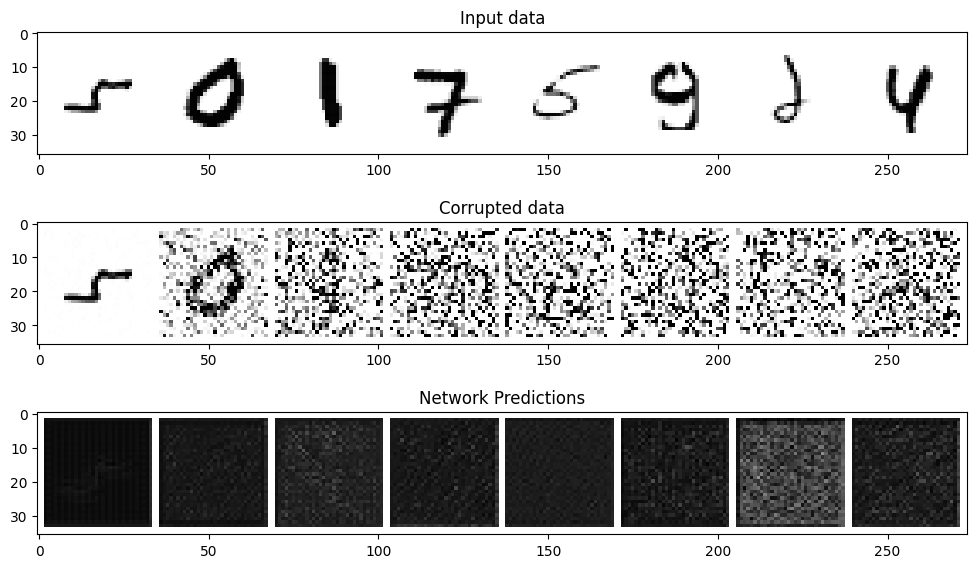

Finished epoch 0. Average loss for this epoch: 0.027415


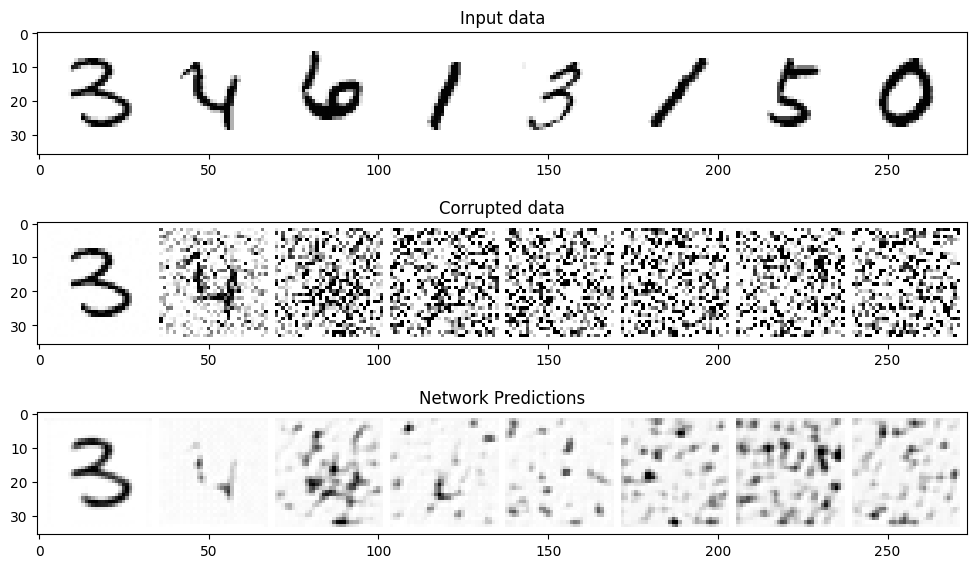

Finished epoch 1. Average loss for this epoch: 0.009161


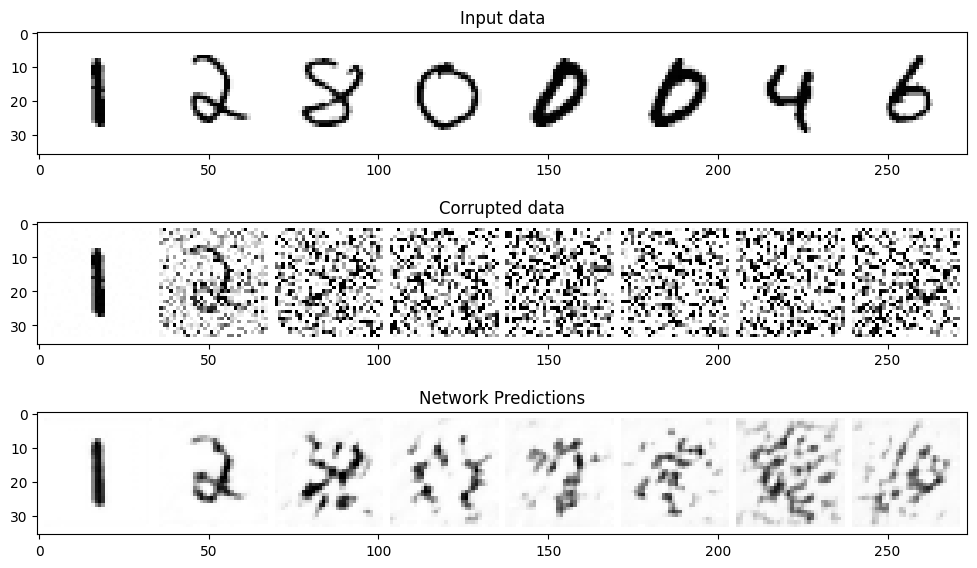

Finished epoch 2. Average loss for this epoch: 0.019393


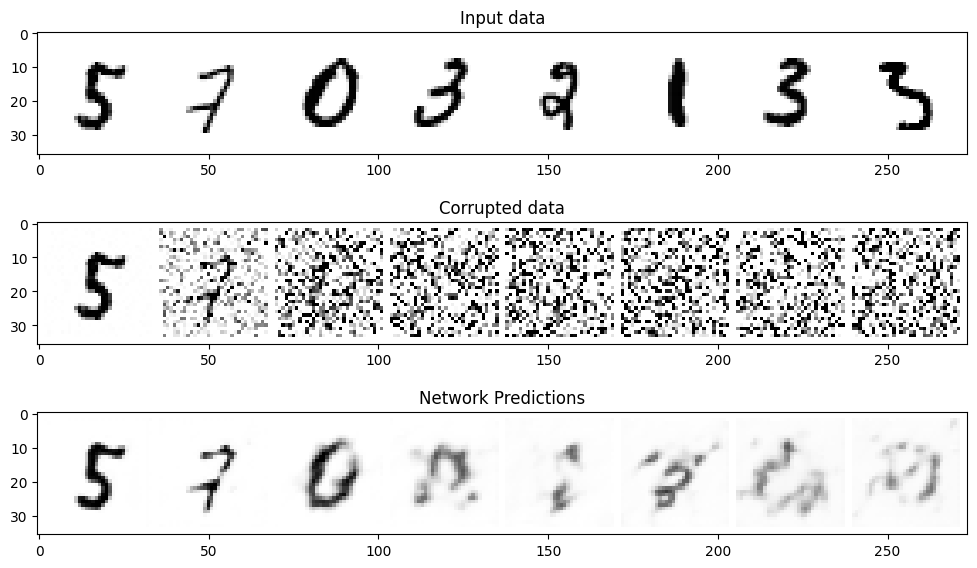

Finished epoch 3. Average loss for this epoch: 0.027309


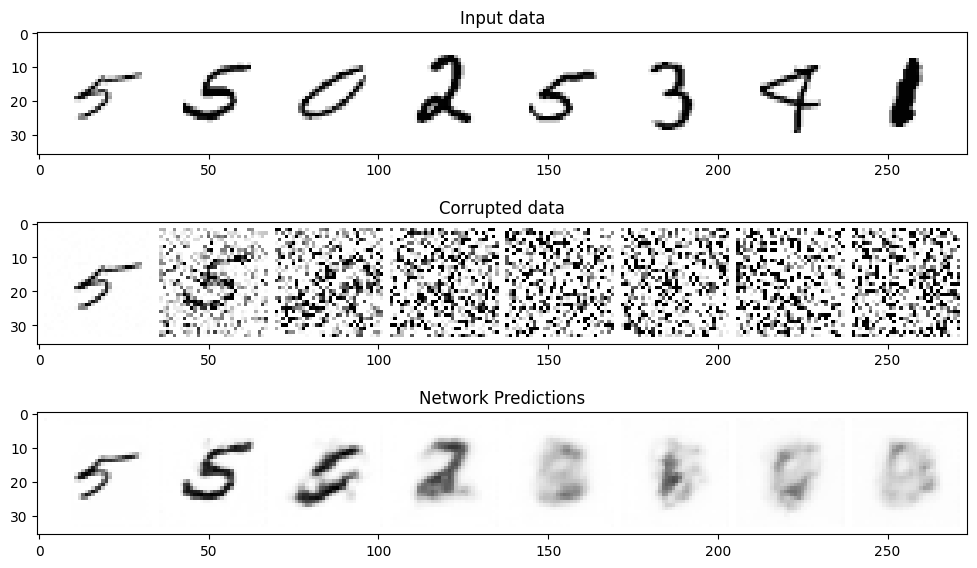

Finished epoch 4. Average loss for this epoch: 0.032251


In [ ]:
etl, btl, evl, bvl = train(
    dataset,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    device,
    val_dataloader
)

(0.0, 0.1)

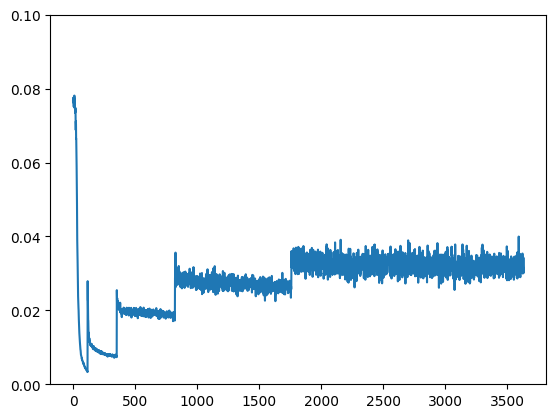

In [93]:
# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

In [94]:
#@title Save the model

path = "trained_model.pt"
torch.save(model, path)

In [95]:
#@title Load model

path = "trained_model.pt"
model = torch.load(path, weights_only=False)
model.to(device)
model.eval()
print("OK")

OK


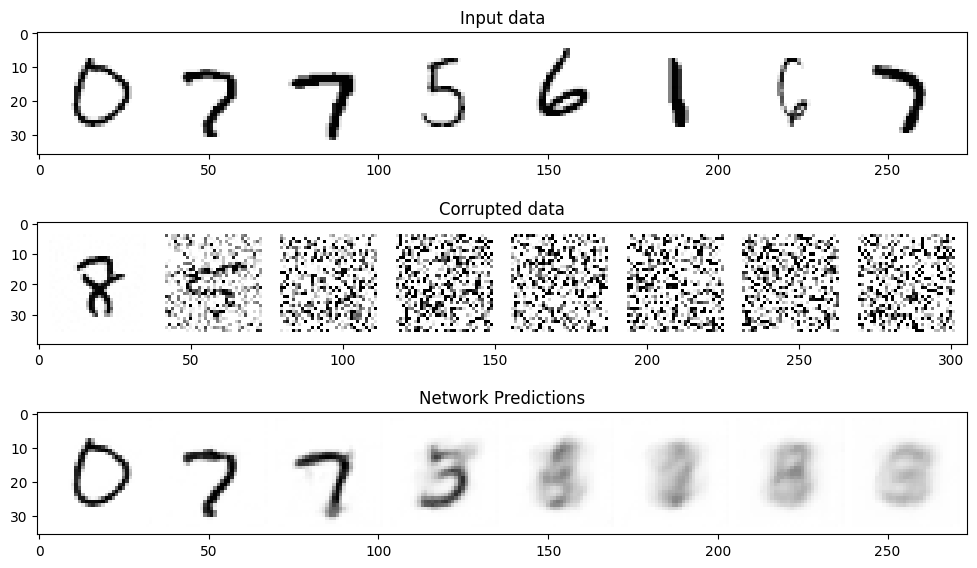

In [96]:
#@title Sampling

# Fetch some data
x, y = next(iter(train_dataloader))
batch_size = 8
x = x[:batch_size] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
t = torch.linspace(0, T-1, batch_size).long().to(device)
noise = torch.randn_like(x).to(device)
x = x.to(device)
noisy_x = sched.add_noise(x, noise, t).to(device)

# Get the model predictions
with torch.no_grad():
    preds = model.unet(noisy_x, t).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x.cpu())[0].clip(0, 1), cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x.cpu())[0].clip(0, 1), cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap='Greys')

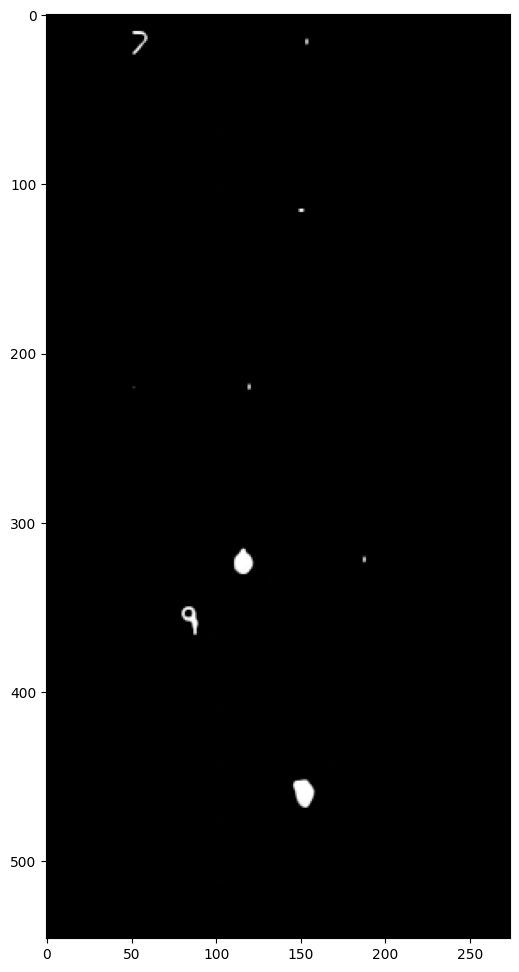

In [97]:
n_steps = 120
x = model.sample(n_steps, BATCH_SIZE)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

im = torchvision.utils.make_grid(x.detach().cpu())[0].clip(0, 1)
ax.imshow(im, cmap='gray')